# Introduction
- Project's topic: **ANALYZING THE IMPACT OF VACCINATION ON HUMAN LIFESPANS IN DEVELOPED AND DEVELOPING NATIONS**
- Author: Wendy Ha (Swinburne University of Technology)
- Dataset: [Life Expectancy (WHO)](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who) 




# Import Libraries


In [ ]:
pip install pycountry-convert

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
import plotly.express as px
import pycountry_convert as pc
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

In [ ]:
# OPTIONAL:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# OPTIONAL: Colab includes the google.colab.data_table package that can be used to display large pandas dataframes as an interactive data table. It can be enabled with:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Life Expectancy Data.csv to Life Expectancy Data (6).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Life Expectancy Data.csv']), delimiter=',')
df.dataframeName = 'Life Expectancy Data.csv'
# Dataset is now stored in a Pandas Dataframe

# Data Cleaning and EDA

##Preview Granularity/Variables description

In [ ]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Formatting issues: 
- Incorrect column name: Thinness 1-19 years 
- Spacing on column name: Life expectancy, Measles, BMI, under-five deaths, HIV/AIDS, thinness 1-19, thinness 5-9 years, Diphtheria



```
# Fixing spacing issue
```



In [ ]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols
                    



```
# Fixing incorrect name issue
```



In [ ]:
df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)



```
# Result after formatting
```



In [ ]:
df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_10-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

## Check duplicated rows and columns

In [ ]:
df[df.duplicated()]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling


## Missing values detection



```
# Check missing values in each column
```



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under-five_deaths                2938 non-null   int64  
 12  polio               



```
# Break down null values and the proportion they occuppied in each column
```



In [ ]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[iloc = {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

In [ ]:
nulls_breakdown()

[iloc = 3] life_expectancy has 10 null values: 0.34% null
[iloc = 4] adult_mortality has 10 null values: 0.34% null
[iloc = 6] alcohol has 194 null values: 6.6% null
[iloc = 8] hepatitis_b has 553 null values: 18.82% null
[iloc = 10] bmi has 34 null values: 1.16% null
[iloc = 12] polio has 19 null values: 0.65% null
[iloc = 13] total_expenditure has 226 null values: 7.69% null
[iloc = 14] diphtheria has 19 null values: 0.65% null
[iloc = 16] gdp has 448 null values: 15.25% null
[iloc = 17] population has 652 null values: 22.19% null
[iloc = 18] thinness_10-19_years has 34 null values: 1.16% null
[iloc = 19] thinness_5-9_years has 34 null values: 1.16% null
[iloc = 20] income_composition_of_resources has 167 null values: 5.68% null
[iloc = 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 14 contain null values; 63.64% columns contain null values.


Findings: 
- 16/22 columns contain null value
- Almost half of the data in the BMI column are missing, this column should be removed from the analysis.

## Dealing with Missing values



```
# Remove BIM column, with contains nearly 50% of null value. 
```



In [ ]:
df.drop(columns='bmi', inplace=True)



```
# The data set after drop "BMI" column has 21 records.
```



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  under-five_deaths                2938 non-null   int64  
 11  polio                            2919 non-null   float64
 12  total_expenditure   



```
# Using the mean (average) value of the year to replace missing values.
```



In [ ]:
imputed_data = []
for year in list(df.year.unique()):
    year_data = df[df.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
df = pd.concat(imputed_data).copy()



```
# Double check the data now does not contain null values
```



In [ ]:
nulls_breakdown(df)

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


## Outlier detection

###Checking Data Distribution with Histogram and Box Plots

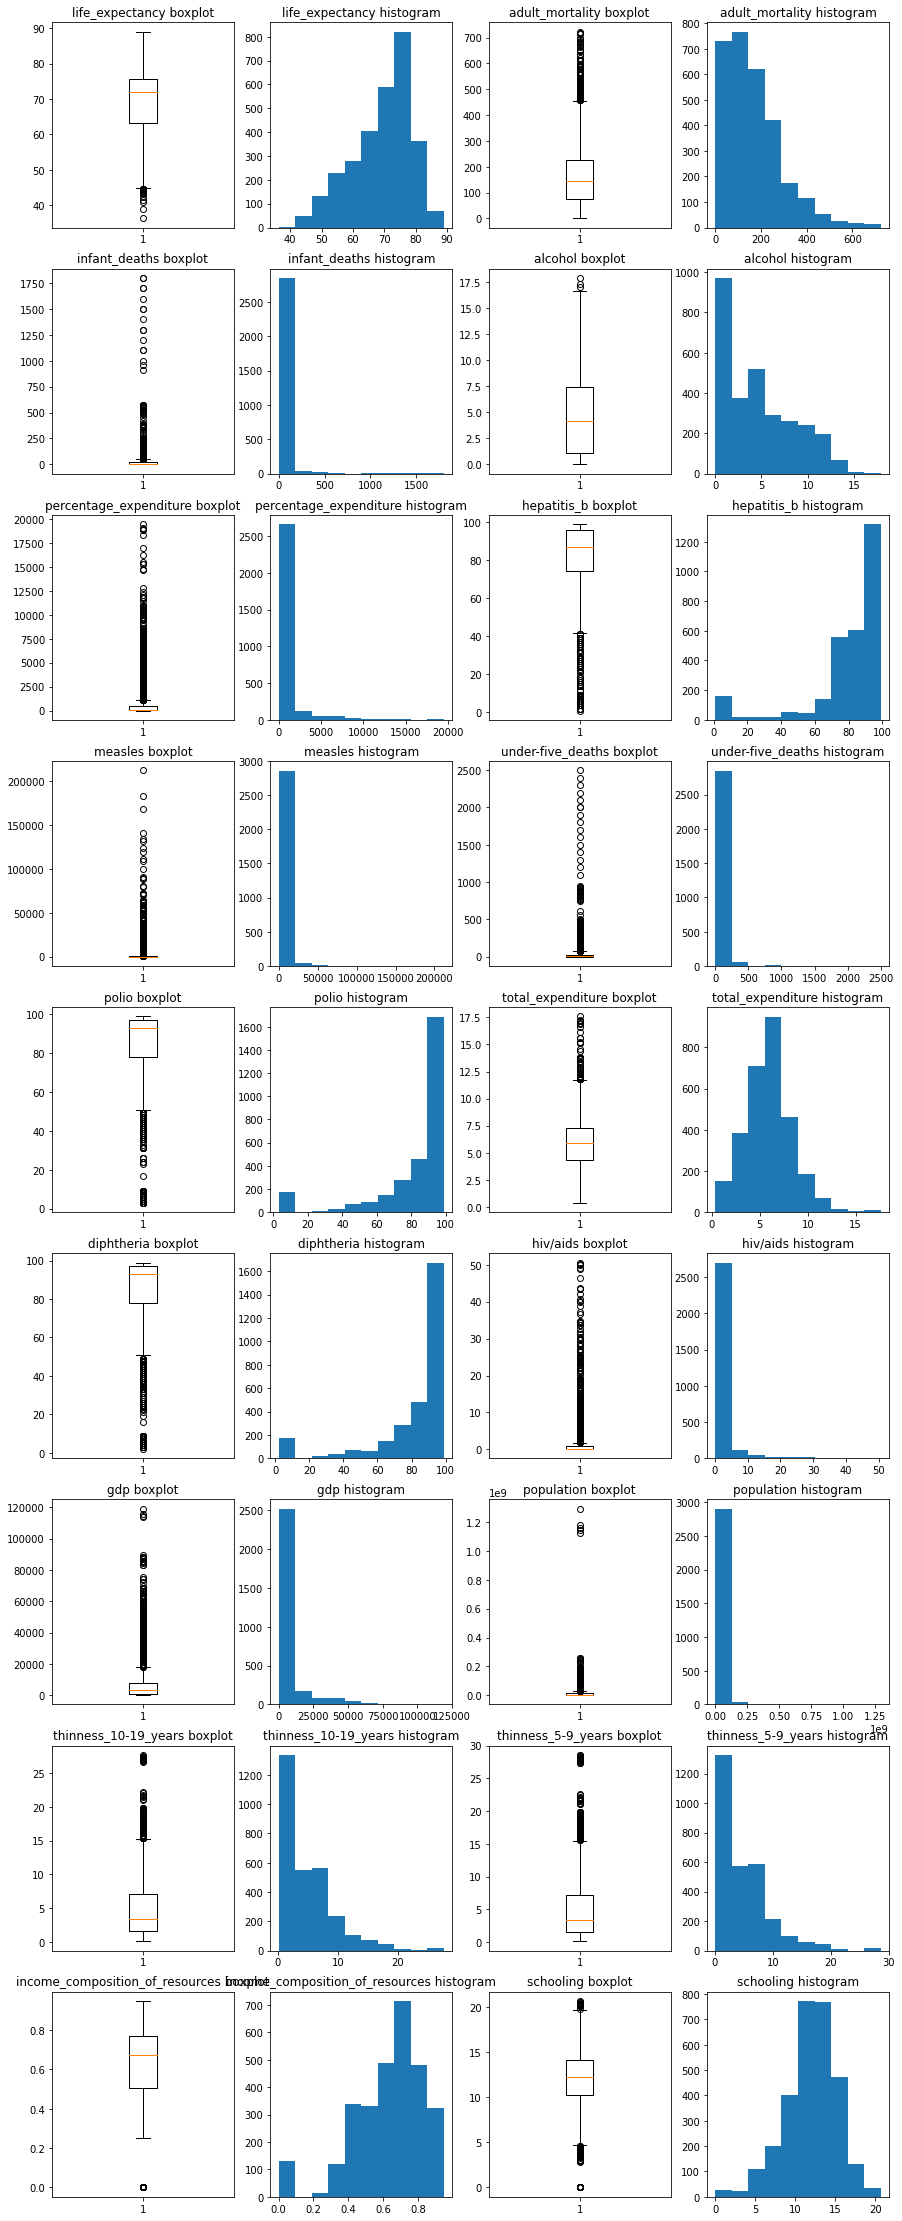

In [ ]:
cont_vars = list(df.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()
outliers_visual(df)

### Retrieving outliers’ data with IQR score

In [ ]:
def outlier_count(col, data=df):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [ ]:
for col in cont_vars:
    outlier_count(col)

---------------life_expectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adult_mortality---------------
Number of outliers: 86
Percent of data that is outlier: 2.93%
---------------infant_deaths---------------
Number of outliers: 315
Percent of data that is outlier: 10.72%
---------------alcohol---------------
Number of outliers: 3
Percent of data that is outlier: 0.1%
---------------percentage_expenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitis_b---------------
Number of outliers: 222
Percent of data that is outlier: 7.56%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-five_deaths---------------
Number of outliers: 394
Percent of data that is outlier: 13.41%
---------------polio---------------
Number of outliers: 279
Percent of data that is outlier: 9.5%
---------------total_expenditure------------

## Dealing with outliers

In [ ]:
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

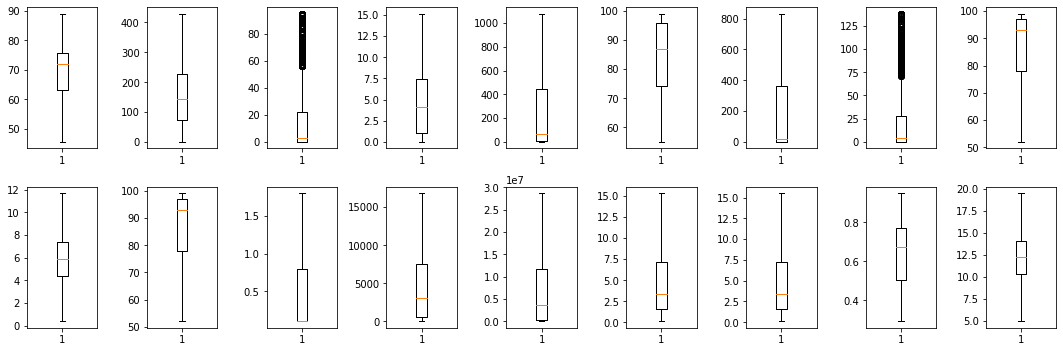

In [ ]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

# Data Visualization

## Question 1: What are the actual factors influencing life expectancy?

In [ ]:
wins_df = df.iloc[:, 0:3]
for col in cont_vars:
    wins_df[col] = wins_dict[col]

In [ ]:
wins_df[cont_vars].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.687851,-0.511204,0.395089,0.488440,0.315120,-0.337887,-0.542069,0.573291,0.222306,0.578952,-0.796939,0.501011,0.011363,-0.514966,-0.512694,0.792878,0.742306
adult_mortality,-0.687851,1.000000,0.337589,-0.202257,-0.325194,-0.208622,0.213251,0.354262,-0.359538,-0.131978,-0.359110,0.599358,-0.320777,0.002595,0.345060,0.352878,-0.523557,-0.470367
infant_deaths,-0.511204,0.337589,1.000000,-0.282638,-0.317306,-0.299807,0.586081,0.993394,-0.404745,-0.175293,-0.400489,0.366381,-0.291569,0.314715,0.409574,0.418674,-0.422499,-0.457077
alcohol,0.395089,-0.202257,-0.282638,1.000000,0.378069,0.106352,-0.197193,-0.283588,0.265830,0.308434,0.272948,-0.193443,0.389598,-0.036283,-0.436755,-0.427166,0.475112,0.519757
percentage_expenditure,0.488440,-0.325194,-0.317306,0.378069,1.000000,0.122870,-0.194687,-0.318484,0.268385,0.159830,0.268411,-0.295791,0.712940,-0.070366,-0.331693,-0.333748,0.556006,0.530422
hepatitis_b,0.315120,-0.208622,-0.299807,0.106352,0.122870,1.000000,-0.266487,-0.310744,0.608008,0.071100,0.647198,-0.278977,0.172066,-0.004936,-0.134103,-0.139528,0.299493,0.290399
measles,-0.337887,0.213251,0.586081,-0.197193,-0.194687,-0.266487,1.000000,0.588662,-0.320104,-0.161737,-0.315164,0.226305,-0.183792,0.222488,0.359571,0.364201,-0.274976,-0.329274
under-five_deaths,-0.542069,0.354262,0.993394,-0.283588,-0.318484,-0.310744,0.588662,1.000000,-0.429254,-0.175207,-0.425971,0.403528,-0.299079,0.293939,0.416517,0.421033,-0.447862,-0.482185
polio,0.573291,-0.359538,-0.404745,0.265830,0.268385,0.608008,-0.320104,-0.429254,1.000000,0.164149,0.855849,-0.475611,0.309033,0.003618,-0.288660,-0.287206,0.515361,0.509788
total_expenditure,0.222306,-0.131978,-0.175293,0.308434,0.159830,0.071100,-0.161737,-0.175207,0.164149,1.000000,0.176715,-0.110629,0.146954,-0.105257,-0.285700,-0.294560,0.185535,0.259746


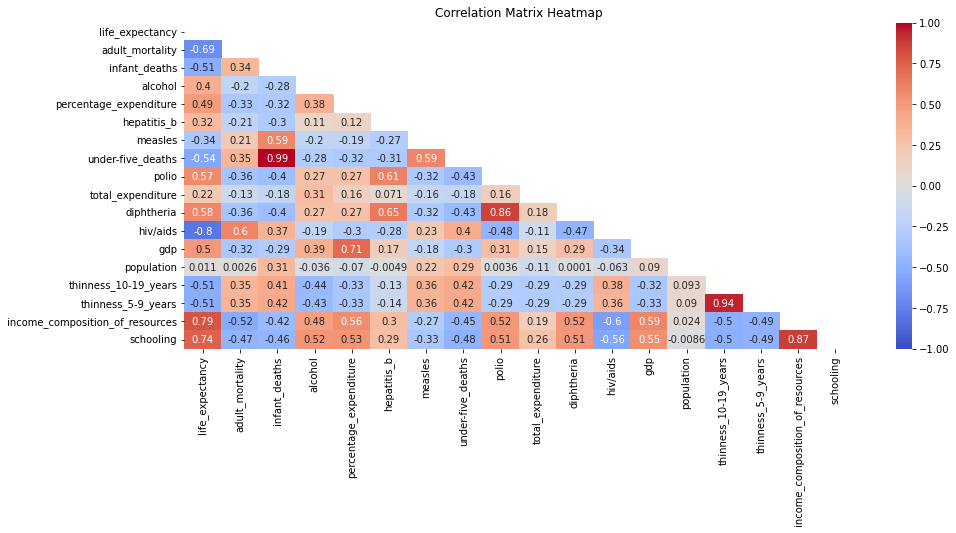

In [ ]:
mask = np.triu(wins_df[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_df[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Findings: 
- There is no significant correlation between life expectancy and population 
- The factors have positive correlation with life expectancy: alcohol, percentage expenditure, hepatitis B, polio, total expenditure, diphtheria, GDP, income composition of resources, schooling.
- The factors have negative correlation with life expectancy: adult mortality, infant deaths, measles, under five deaths, HIV/AIDS, thinnes 10-19 years, thinnes 5-9 years


## Question 2: What effect does immunisation coverage have on life expectancy in two groups developing and developed countries?

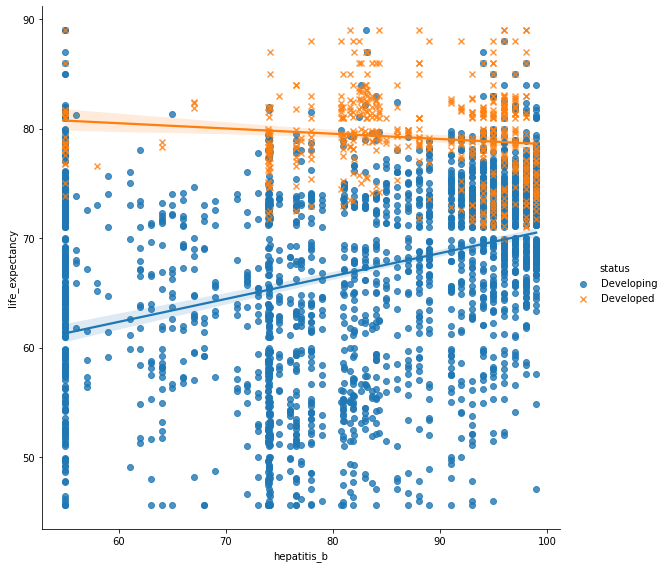

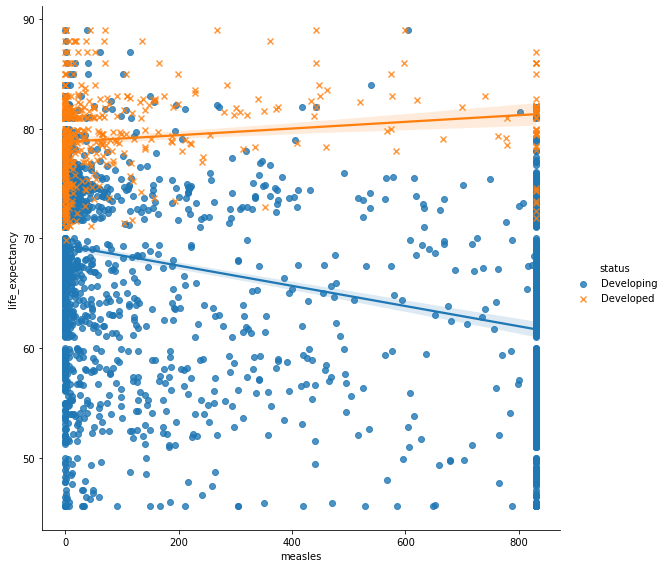

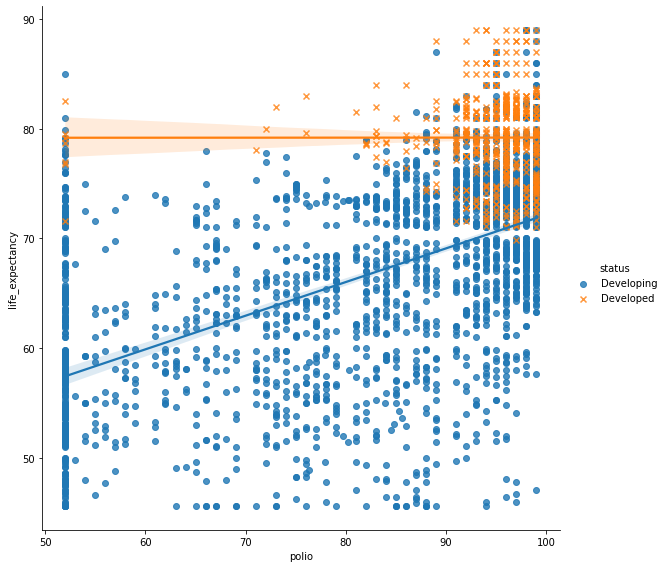

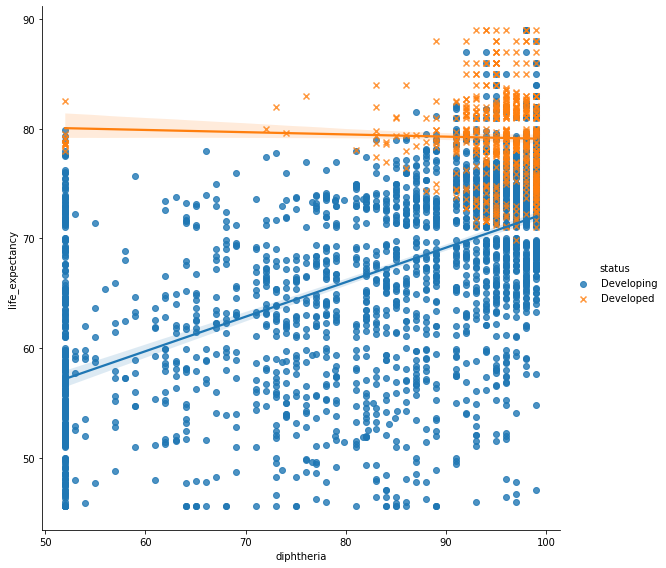

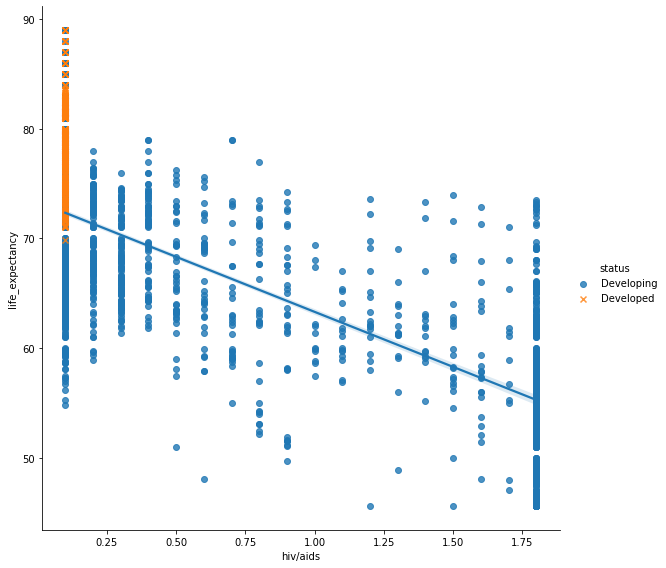

In [ ]:
sns.pairplot(wins_df, x_vars=["hepatitis_b"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");
sns.pairplot(wins_df, x_vars=["measles"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");
sns.pairplot(wins_df, x_vars=["polio"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");
sns.pairplot(wins_df, x_vars=["diphtheria"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");
sns.pairplot(wins_df, x_vars=["hiv/aids"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");


Findings: 
- Between 2000 and 2015, there has been a slight reduction in the life expectancy value of wealthy countries such as New Zealand, Japan, Danmark, however, in developing countries like Afghanistan or Bangladesh, the life expectancy of people was originally low but is progressively growing up. It indicates that developing countries are taking steps to establish mandatory Hepatitis B vaccination for 1-year-old children. Polio and diphtheria immunization coverage have followed the same pattern. 

- The number of measles cases, on the other hand, experience the opposite trend. According to the graph, vaccinations against measles are properly available in industrialised countries, which explains why the life expectancy in these countries is continually rising. However, in developing nations, life expectancy is falling rapidly from 70 to around 60 years old after a decade and a half. It might be because of a lack of vaccine suppliers or the government's failure to roll out measles immunisation in certain nations. 

- In the poor countries , HIV/AIDS is one of the most serious problem influencing life expectancy. In 2000, the average life expectancy in these nations was above 70 years, however due to the outbreak of HIV/AIDS epidemic, life expectancy has plummeted to approximately 67 years in 2015. Population growth and illiteracy possibly are the main causes of this issue.

## Question 3: What effect does Schooling and Alcohol have on Life Expectancy?

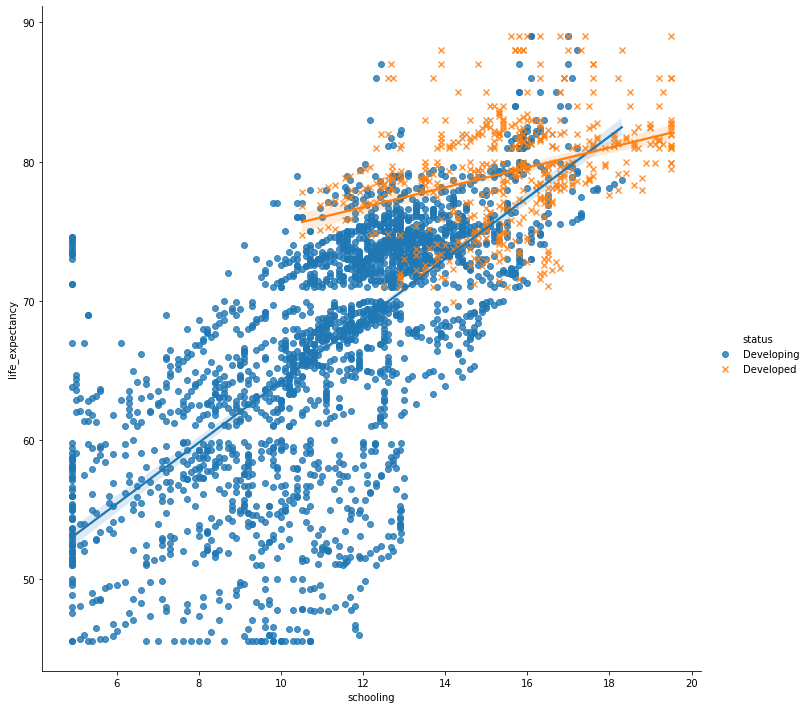

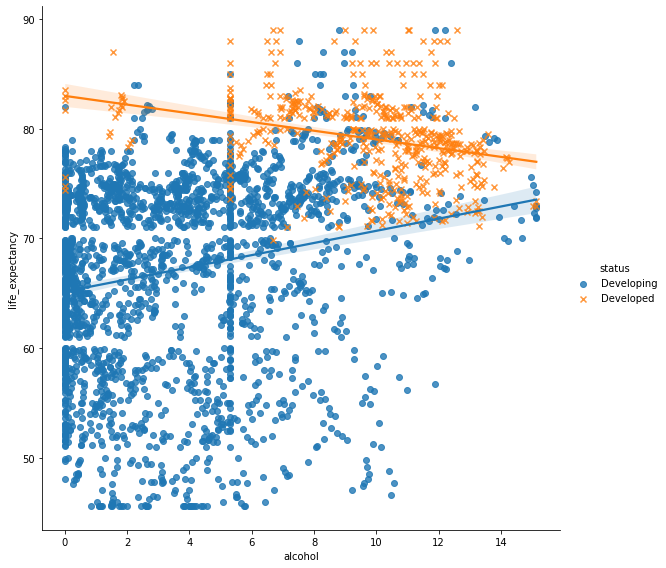

In [ ]:
sns.pairplot(wins_df, x_vars=["schooling"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=10, kind="reg");
sns.pairplot(wins_df, x_vars=["alcohol"], y_vars=["life_expectancy"],
             hue="status",markers=["o", "x"], height=8, kind="reg");

Findings: 
- It is clear that education has a greater impact on boosting lifespan in developing nations than in developed countries. The analysis on HIV/AIDS above can be seen as a typical example, when the number of people attending school increases, it can assist to reduce the mortality rate from the HIV virus. Education has a positive impact on enhancing life expectancy in wealthy nations as well, however since these countries have been investing in education for a long time, the improvement is not as noticeable as it is in developing ones.

- Because industrialised countries can produce and distribute alcohol domestically at a low cost, the amount of alcohol consumed in developed nations is larger than in developing countries. As a consequence, there is a negative correlation between alcohol consumption and life expectancy in wealthy countries. The more individuals who drink alcohol, the shorter their life expectancy becomes. On the other hand in developing countries, because alcohol is expensive and not accessible to everyone, there are fewer drinkers than in developed ones (Charles 2015). Due to that, the data is insufficient for analysis. The alcohol scatters plot above does not imply that in developing nations, alcohol consumption and life expectancy have a positive correlation.

## Question 4: What effect does GDP have on life expectancy?

In [ ]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}
continent = []
for country in df['country']:
    try:
        continent.append(continents[(country_alpha2_to_continent_code(country_name_to_country_alpha2(country)))])
    except:
        continent.append("Africa")
    
df["continent"] = continent
to_bubble = df[["country", "year", "life_expectancy", "gdp", "population", "continent"]]
to_bubble.dropna(inplace = True)

In [ ]:
df = px.data.gapminder()

fig = px.scatter(to_bubble, x="gdp", y="life_expectancy",
                 size="population", color="continent",
                 hover_name="country", log_x=True, size_max=50)
fig.show()

# Conclusion

1. The World Health Organization's data set on variables impacting life expectancy still has a lot of missing numbers. These missing data values are primarily seen in nations with small populations, where data sources are not abundant. 
2. This dataset also contains numerous outliers that have been reprocessed using the Winsorization approach. 
3. Many developing countries are doing a good job of promoting vaccination against hepatitis B, polio, and diphtheria among 1-year-old children in order to improve the life expectancy of their citizens. However, the availability of the measles vaccine still needs to improve because they is one of the most dangerous causes of the recent life expectancy declines. 
4. One of the diseases that has a substantial influence on life expectancy in underdeveloped countries is HIV/AIDS. This directly highlights the important role of education in resolving this issue. If the number of people in developing countries who go to school increases, so does the number of HIV/AIDS infections and the mortality rate by HIV/AIDS will reduced. As a result, life expectancy possibly rises. 
5. Furthermore, Alcohol intake is a severe problem in industrialised countries, with a detrimental influence on life expectancy. When the amount of alcohol consumed gets out of control (Centers for Disease Control and Prevention 2015), it has a negative impact on health, which in turn is a decrease in life expectancy.